# Load libraries

In [1]:
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

print("Plot libraries")
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns


print("Computing libraries")
import pandas as pd
import numpy as np


print("Root libraries")
import ROOT
import uproot


from tqdm.notebook import tqdm


print("Tensorflow libraries")
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters


print("Sklearn libraries")
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, matthews_corrcoef

import joblib

Plot libraries
Computing libraries
Root libraries
Welcome to JupyROOT 6.30/04
Tensorflow libraries


2024-06-14 15:12:31.005265: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sklearn libraries


# Config CPU/GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.optimizer.set_jit(True)


tf.config.threading.set_inter_op_parallelism_threads(4)  # Adjust the number of threads as needed
tf.config.threading.set_intra_op_parallelism_threads(4)  # Adjust the number of threads as needed

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16014587243091649742
xla_global_id: -1
]


# Config

In [3]:
train = True
optimize = True
load = not train
plot_data = True
limits = False


metric_monitoring = 'val_loss'
metric_monitoring_tuner = 'val_accuracy'
patience = 5
epochs_train = 100
epochs_tuner = 10
batch_size = 32
tune_trials = 15

In [4]:
path_fig = f'../Fig/WZ_vs_others_3_WW/'
if not os.path.exists(path_fig):
        os.makedirs(path_fig)

folder = []

for i in folder:
    if not os.path.exists(path_fig+i):
        os.makedirs(path_fig+i)

# Load DATA

In [5]:
parameters = []
label = []
limite_m = []
limite_p = []

with open("/eos/user/m/mdubau/SWAN_projects/wz-dnn/variables.txt", "r") as file_variables:
    for line in file_variables:
        columns = line.split(";")
        parameters.append(columns[0])
        limite_m.append(float(columns[1]))
        limite_p.append(float(columns[2]))

    

print("Variables")
for i in range(len(parameters)):
    print(parameters[i])
        


    
print("\n")
print("Number of parameters      : ",len(parameters))

Variables
Njets
mJJ
Deta_jj
Dphi_jj
eta_W
Pt_W
Pt_Z
Ptjet1
Etajet1
Phijet1
centrality_jet
centrality
DR_jZ
Ptjet2
MtWZ
aZylW
cosThetaZ_rec
cosThetaW_rec
RpThard2
Etajet2
Phijet2
pt1
eta1
pt2
eta2
pt3
eta3
phi1
phi2
phi3
cosThetaV_rec
WZpT_rec
MET
ZlepDPhi
WlepDPhi
Ejet1
Ejet2
pTjMean_rec
ApTj_rec
r21_rec
cosThetaVjj_rec


Number of parameters      :  41


In [6]:
files_names = """
histo.run2.WZlllnu_MGH7EG_EW_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_noSkim.root;
histo.run2.WZlllnu_Sherpa2212_EW_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_W0Z0Pol_V3.root;
histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_W0ZTPol_V3.root;
histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_WTZ0Pol_V3.root;
histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_WTZTPol_V3.root;
histo.run2.WZlllnu_MGPy8EG_NLO_Ext.root;
histo.run2.WZlllnu_Sherpa2212_noSkim.root;
histo.run2.ZZ_MGPy8EG_EW.root;
histo.run2.VVV_Sherpa.root;
histo.run2.ZZ_Sherpa222.root;
histo.run2.Zgamma_Sherpa224.root;
histo.run2.Zll_PowHeg.root;
histo.run2.tZ_aMcAtNloPythia.root;
histo.run2.ttbarV_aMCatNLO.root;
histo.run2.ttbar_PowHegPythia8.root;
"""

files_list = [name.strip() for name in files_names.split(';') if name.strip()]
files_list_simple = [name.replace("histo.run2.", "").replace(".root", "") for name in files_list]

files_list_WZ = [files_list[i] for i in range(13)]
print(files_list_WZ)

files_list_others = [files_list[i+13] for i in range(len(files_list)-13)]
print(files_list_others)

['histo.run2.WZlllnu_MGH7EG_EW_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_noSkim.root', 'histo.run2.WZlllnu_Sherpa2212_EW_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_W0Z0Pol_V3.root', 'histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_W0ZTPol_V3.root', 'histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_WTZ0Pol_V3.root', 'histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_WTZTPol_V3.root', 'histo.run2.WZlllnu_MGPy8EG_NLO_Ext.root', 'histo.run2.WZlllnu_Sherpa2212_noSkim.root']
['histo.run2.ZZ_MGPy8EG_EW.root', 'histo.run2.VVV_Sherpa.root', 'histo.run2.ZZ_Sherpa222.root', 'histo.run2.Zgamma_Sherpa224.root', 'histo.run2.Zll_PowHeg.root', 'histo.run2.tZ_aMcAtNloPythia.root', 'histo.run2.ttbarV_aMCatNLO.root', 'histo.run2.ttbar_PowHegPythia8.root']


In [7]:
def load_data(file_path, parameters):
    print("Loading file : ",file_path)
    
    with uproot.open(file_path + ":ntWZVBS_SR_KinRecGen") as file_tree:
        data = file_tree.arrays(parameters, library="pd")
        
    return np.array(data)


path = "/eos/user/m/mdubau/samples/VBS/"


print("WZ")
size = 0
for i in files_list_WZ:
    data = load_data(path+i,parameters)
    size += data.shape[0]
    
    if i == files_list_WZ[0]:
        signal_data = data
    else:
        signal_data = np.concatenate((data,signal_data),axis=0)
        
assert size == signal_data.shape[0]
print("Number of events : ",signal_data.shape[0])


print("\n")

      
print("others")
size = 0
for i in files_list_others:
    data = load_data(path+i,parameters)
    size += data.shape[0]
    
    if i == files_list_others[0]:
        background_data = data
    else:
        background_data = np.concatenate((data,background_data),axis=0)
        
assert size == background_data.shape[0]
print("Number of events : ",background_data.shape[0])

WZ
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGH7EG_EW_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_Sherpa2212_EW_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_W0Z0Pol_V3.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_W0ZTPol_V3.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_CKKWL_LO_WTZ0Pol_V3.root
Loading file :  /eos/user/m/mdubau/samples/

In [8]:
indices = np.where(signal_data[:,parameters.index("MtWZ")] <= 5000)[0]


signal_data = signal_data[indices]
print(signal_data.shape[0])



indices = np.where(background_data[:,parameters.index("MtWZ")] <= 5000)[0]

background_data = background_data[indices]
print(background_data.shape[0])

811038
384054


In [9]:
signal_label = np.ones(signal_data.shape[0])
background_label = np.zeros(background_data.shape[0])

In [10]:
def plot(list_data , parameters , path_fig , fig_name , list_colors, is_legend, legend, label, x_min, x_max, limits):

    num_parameters = len(parameters)
    num_rows = (num_parameters - 1) // 7 + 1

    fig, axes = plt.subplots(nrows=num_rows, ncols=7, figsize=(18, 3 * num_rows))

    axes = axes.flatten()

    for i in tqdm(range(num_parameters), desc='Plot'):
        ax = axes[i]
        
        if len(list_data) == 1:
            ax.hist(list_data[0][:, i], bins=50, color=list_colors[0], alpha=0.7)
        else:
            for j in range(len(list_data)):
                ax.hist(list_data[j][:, i], bins=50, color=list_colors[j], alpha=0.7, histtype='step', density=True, log=True)

        ax.set_title(parameters[i])
        ax.set_xlabel(r""+label[i])
        ax.set_ylabel('Events')
        if limits:
            ax.set_xlim(x_min[i], x_max[i])

    
    if 7*num_rows > len(parameters):
        for i in range(7*num_rows - len(parameters)):
            fig.delaxes(axes[-(i+1)])

            
    if is_legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.extend(legend)        
        fig.legend(handles=handles, loc='upper center', ncol=len(legend), bbox_to_anchor=(0.5, -0.025), frameon=False)

    plt.tight_layout()
    plt.savefig(path_fig+fig_name,bbox_inches="tight")
    plt.show()

Plot:   0%|          | 0/41 [00:00<?, ?it/s]

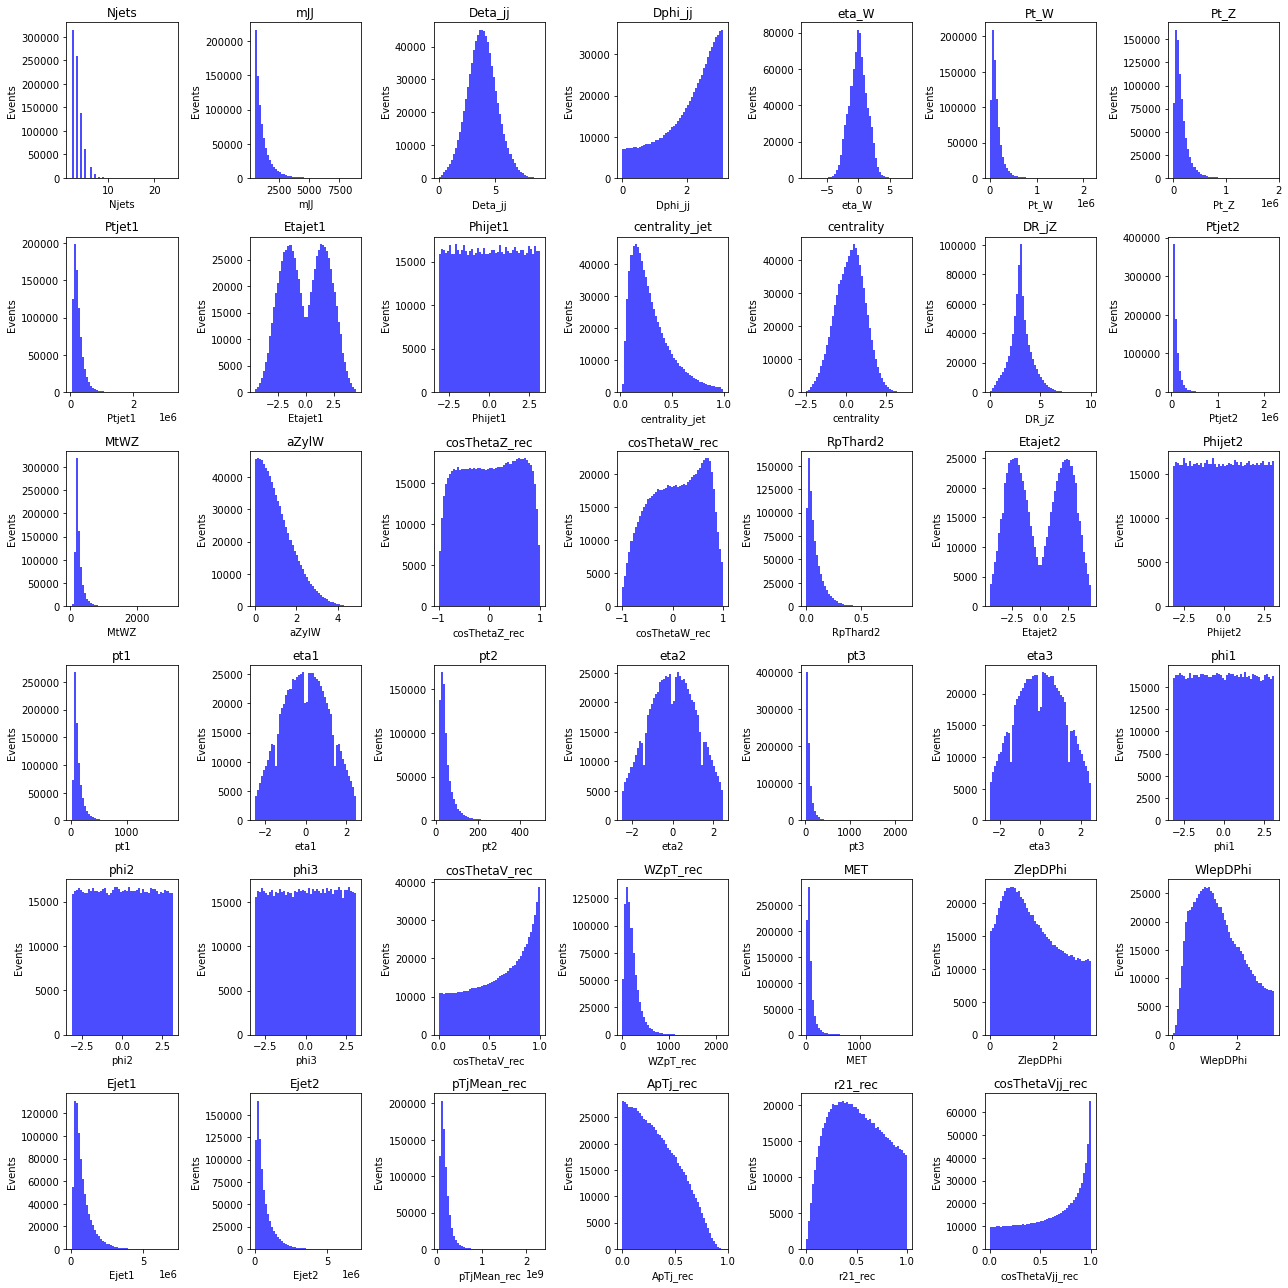

Plot:   0%|          | 0/41 [00:00<?, ?it/s]

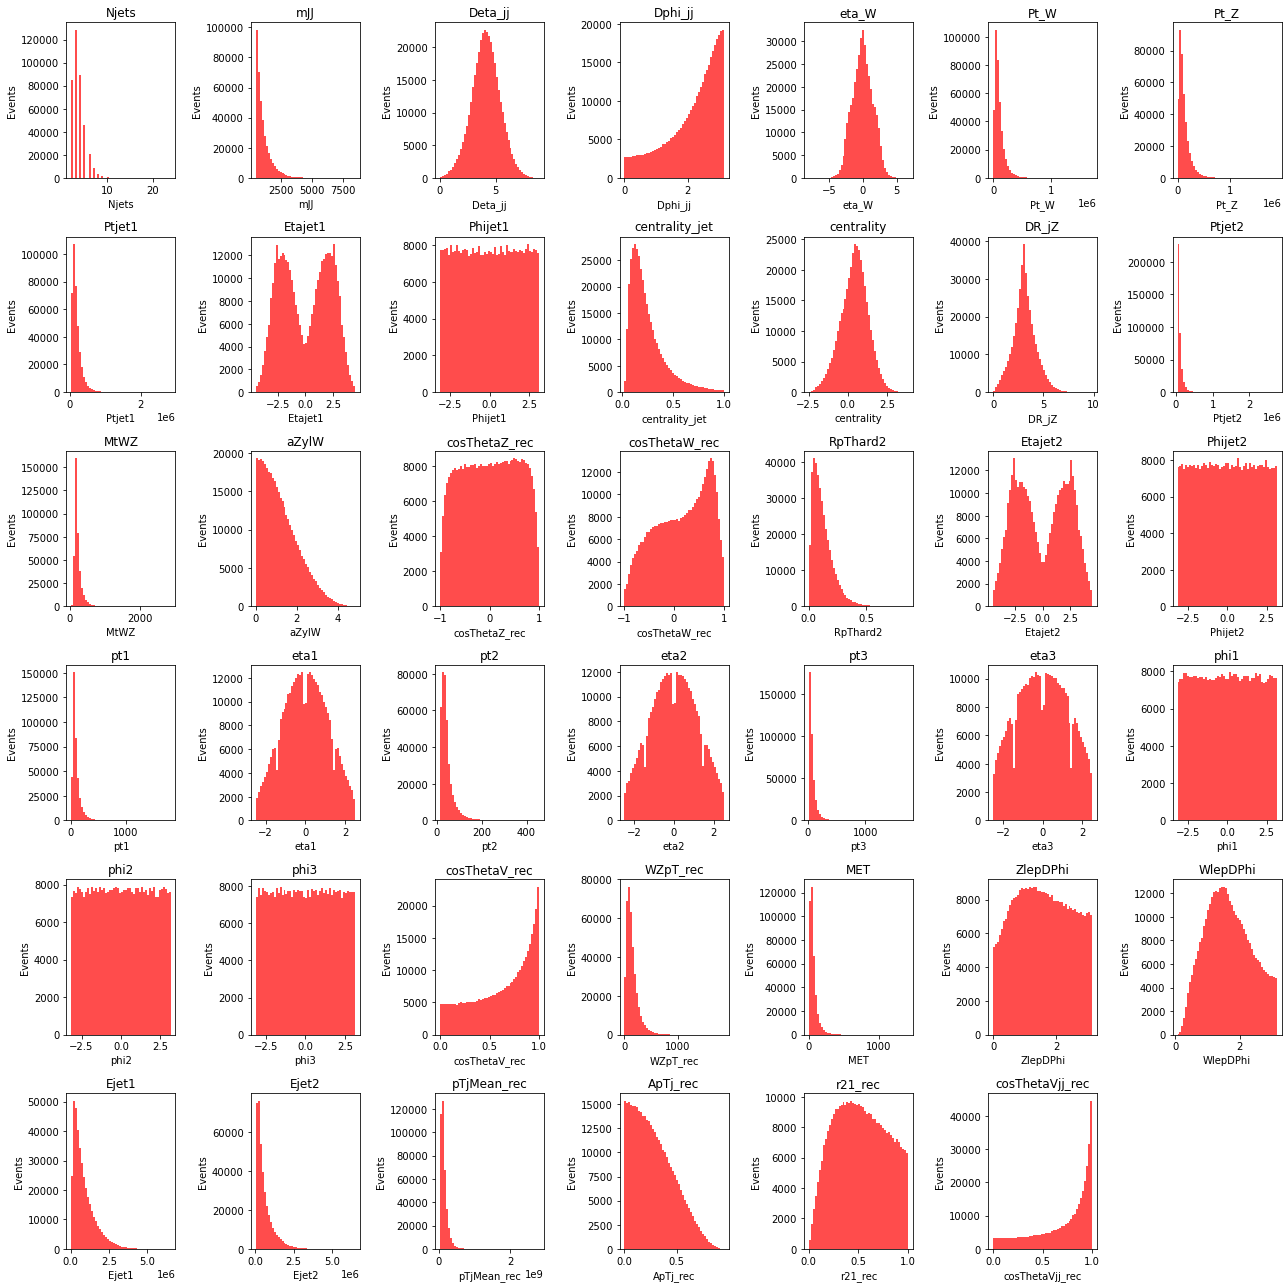

Plot:   0%|          | 0/41 [00:00<?, ?it/s]

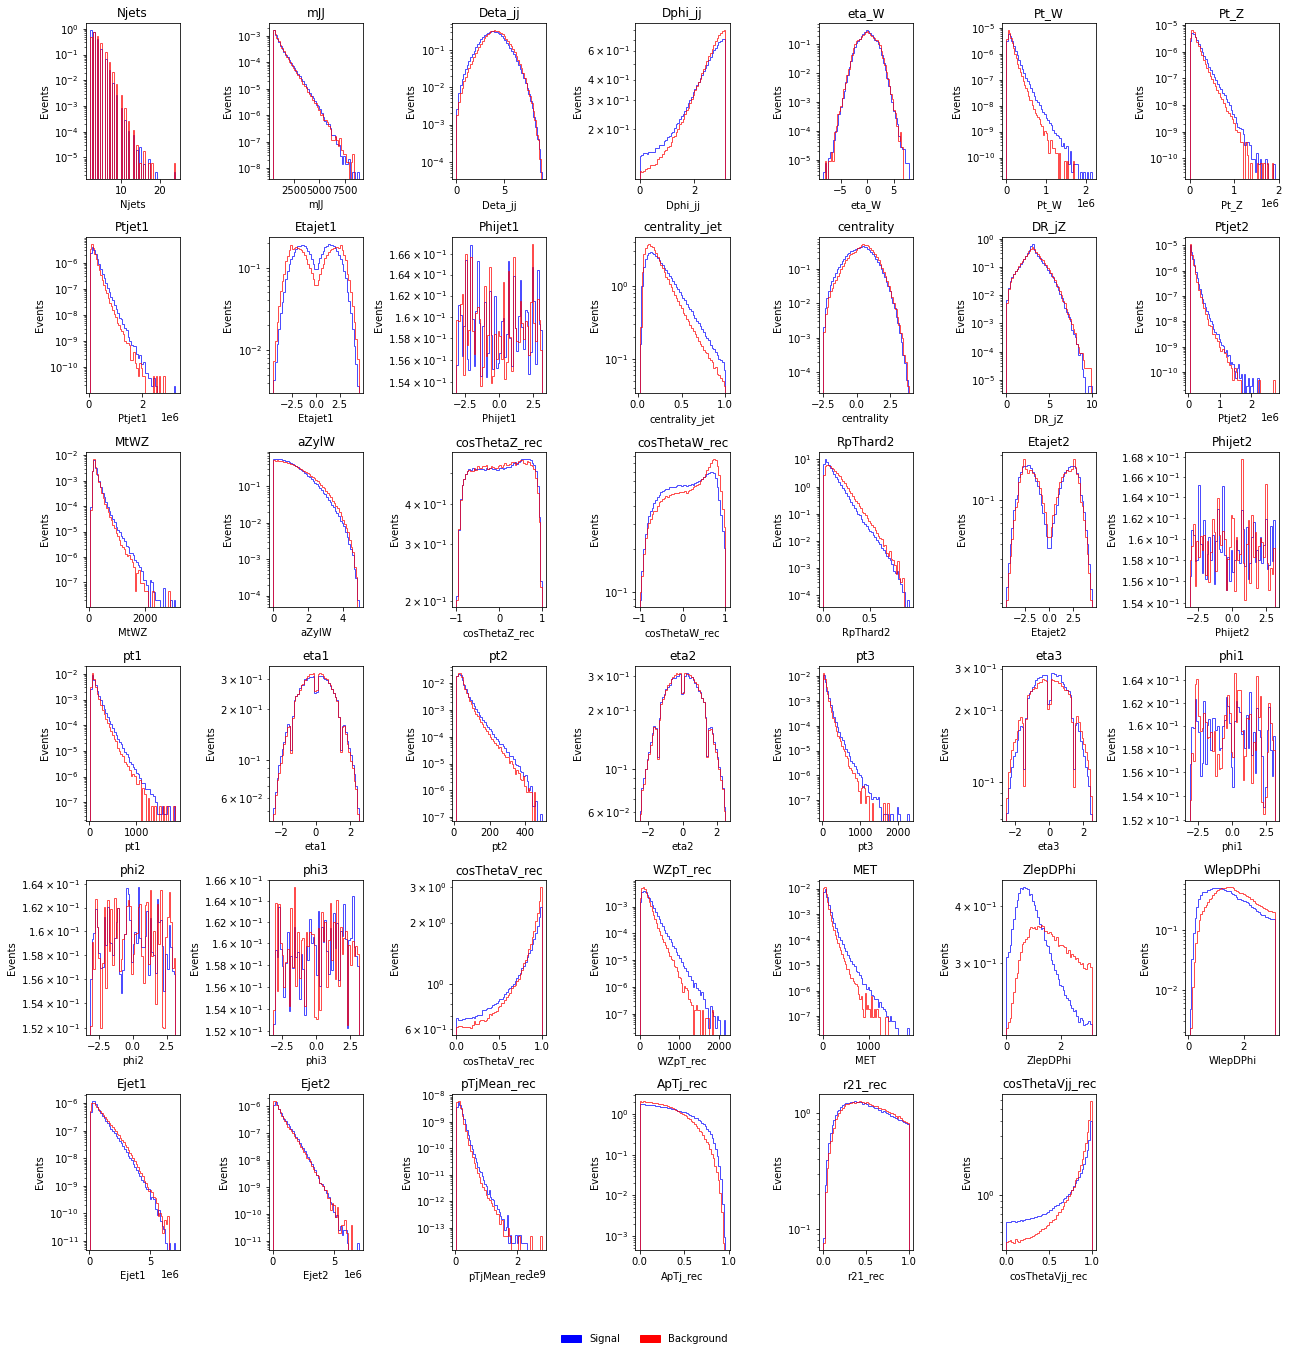

In [11]:
legend_signal = mpatches.Patch(color='blue', label='Signal')   
legend_background = mpatches.Patch(color='red', label='Background')
legend = [legend_signal,legend_background]

if plot_data:
    plot([signal_data], parameters, path_fig, "signal_data.pdf", ["blue"],False,[],parameters,False,limite_p,limits)
    plot([background_data], parameters, path_fig, "background_data.pdf", ["red"],False,[],parameters,False,limite_p,limits)
    plot([signal_data,background_data], parameters, path_fig, "signal_background_data.pdf", ["blue","red"],True,legend,parameters,False,limite_p,limits)

## Process DATA

In [12]:
print(signal_data.shape,background_data.shape)
X = np.concatenate((signal_data, background_data), axis=0)
Y = np.concatenate((signal_label, background_label))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(np.shape(X_scaled))

joblib.dump(scaler, f"../Weights/DNN3_WZ_vs_others_WW_scaler.save") 


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)


print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)


print(np.sum(Y_train))
print(X_train.shape)
print(X_test.shape)

(811038, 41) (384054, 41)
(1195092, 41)
(956073, 41) (239019, 41)
(956073,) (239019,)
649028.0
(956073, 41)
(239019, 41)


# Correlation

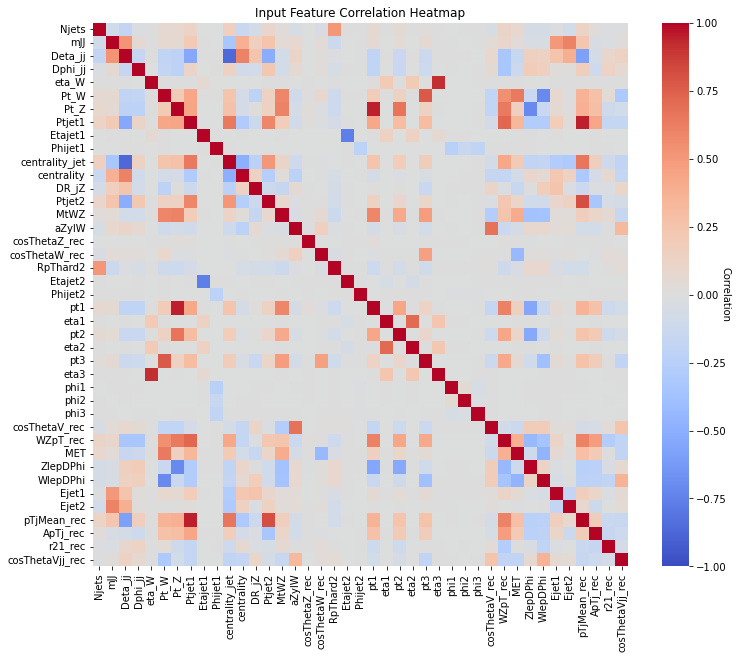

In [13]:
non_zero_var_cols = np.var(X_train, axis=0) != 0

selected_feature_names = [parameters[i] for i in range(len(parameters)) if non_zero_var_cols[i]]

correlation_matrix = np.corrcoef(X_train[:, non_zero_var_cols], rowvar=False)

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", xticklabels=selected_feature_names, yticklabels=selected_feature_names, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.set_label('Correlation',rotation=270)
plt.xticks(rotation=90)
plt.title('Input Feature Correlation Heatmap')
plt.savefig(path_fig+"correlation_matrix.pdf",bbox_inches="tight")
plt.show()

# Hyperparameters tunning

In [14]:

def build_model(hp):
    model = Sequential()
    
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=128, step=32),
                    input_dim=len(parameters), activation='relu'))
    
    for i in range(hp.Int('num_layers', min_value=1, max_value=15)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    return model


if optimize:
    tuner = BayesianOptimization(build_model,
                         objective=metric_monitoring_tuner,
                         max_trials=tune_trials,
                         directory='../tuner_dir',
                         project_name=f'WZ_vs_others_3_WW')
    
    early_stopping_HP = EarlyStopping(monitor=metric_monitoring, patience=patience)

    tuner.search(X_train, Y_train, epochs=epochs_tuner, validation_data=(X_test, Y_test), callbacks=[early_stopping_HP])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters: {best_hps}")

    model = tuner.hypermodel.build(best_hps)

Trial 15 Complete [00h 23m 14s]
val_accuracy: 0.7306824922561646

Best val_accuracy So Far: 0.7317159175872803
Total elapsed time: 06h 27m 22s
Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f81757c6d60>


2024-06-14 15:14:26.221065: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f81140f6580 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-06-14 15:14:26.221126: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-06-14 15:14:26.249244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-14 15:14:26.994711: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Model

In [19]:
if load:
    model = keras.models.load_model(f'../Weights/DNN3_WZ_vs_others_WW_weights.h5')



model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                2688      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 11105 (43.38 KB)
Trainable params: 11105 (43.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Fit

In [17]:
if train:
    early_stopping = EarlyStopping(monitor=metric_monitoring, patience=patience, restore_best_weights=True)
    
    history = model.fit(X_train, Y_train, epochs=epochs_train, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks=[early_stopping])

model.save(f"../Weights/DNN3_WZ_vs_others_WW_weights.h5")

Epoch 1/100
29878/29878 [==============================] - 93s 3ms/step - loss: 0.5522 - accuracy: 0.7147 - val_loss: 0.5455 - val_accuracy: 0.7176
Epoch 2/100
29878/29878 [==============================] - 93s 3ms/step - loss: 0.5399 - accuracy: 0.7230 - val_loss: 0.5371 - val_accuracy: 0.7249
Epoch 3/100
29878/29878 [==============================] - 92s 3ms/step - loss: 0.5354 - accuracy: 0.7263 - val_loss: 0.5349 - val_accuracy: 0.7243
Epoch 4/100
29878/29878 [==============================] - 91s 3ms/step - loss: 0.5327 - accuracy: 0.7282 - val_loss: 0.5347 - val_accuracy: 0.7252
Epoch 5/100
29878/29878 [==============================] - 92s 3ms/step - loss: 0.5307 - accuracy: 0.7295 - val_loss: 0.5324 - val_accuracy: 0.7283
Epoch 6/100
29878/29878 [==============================] - 92s 3ms/step - loss: 0.5293 - accuracy: 0.7307 - val_loss: 0.5387 - val_accuracy: 0.7219
Epoch 7/100
29878/29878 [==============================] - 94s 3ms/step - loss: 0.5281 - accuracy: 0.7312 - val_

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


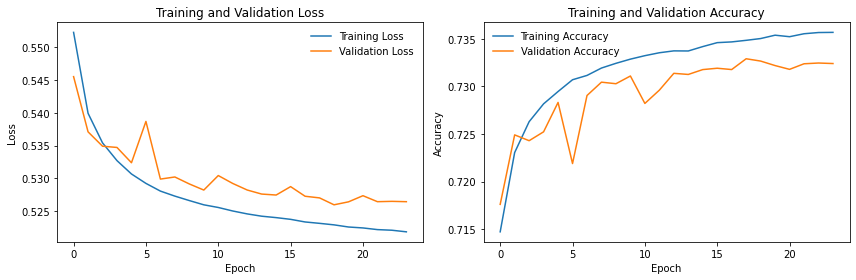

In [20]:
if train:
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(frameon=False)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.savefig(path_fig+"loss_accuracy.pdf",bbox_inches="tight")
    plt.show()

# Accuracy

In [21]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

7470/7470 [==============================] - 15s 2ms/step - loss: 0.5260 - accuracy: 0.7327
Test Loss: 0.5260, Test Accuracy: 0.7327


# Variables rank

In [22]:
@tf.function
def compute_gradients(input_data):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
    gradients = tape.gradient(predictions, input_data)
    return gradients

input_gradients = compute_gradients(tf.convert_to_tensor(X_train, dtype=tf.float32)).numpy()

mean_gradients = np.mean(np.abs(input_gradients), axis=0)

sorted_indices = np.argsort(mean_gradients)[::-1]

for i, idx in enumerate(sorted_indices):
        
    print(f'{parameters[idx]} - Rank: {i+1}, Gradient: {mean_gradients[idx]:.4f}')

MET - Rank: 1, Gradient: 3.5910
pt3 - Rank: 2, Gradient: 1.8346
WZpT_rec - Rank: 3, Gradient: 1.4044
Njets - Rank: 4, Gradient: 1.3197
RpThard2 - Rank: 5, Gradient: 0.8710
MtWZ - Rank: 6, Gradient: 0.7552
Ptjet1 - Rank: 7, Gradient: 0.6693
Pt_W - Rank: 8, Gradient: 0.6525
Ptjet2 - Rank: 9, Gradient: 0.6341
pTjMean_rec - Rank: 10, Gradient: 0.5288
mJJ - Rank: 11, Gradient: 0.4361
pt1 - Rank: 12, Gradient: 0.4031
Ejet1 - Rank: 13, Gradient: 0.2971
Ejet2 - Rank: 14, Gradient: 0.2836
Pt_Z - Rank: 15, Gradient: 0.2476
WlepDPhi - Rank: 16, Gradient: 0.2169
Etajet2 - Rank: 17, Gradient: 0.2034
centrality - Rank: 18, Gradient: 0.1928
eta3 - Rank: 19, Gradient: 0.1877
pt2 - Rank: 20, Gradient: 0.1868
Deta_jj - Rank: 21, Gradient: 0.1853
DR_jZ - Rank: 22, Gradient: 0.1684
centrality_jet - Rank: 23, Gradient: 0.1470
aZylW - Rank: 24, Gradient: 0.1396
cosThetaW_rec - Rank: 25, Gradient: 0.1374
Dphi_jj - Rank: 26, Gradient: 0.1169
ApTj_rec - Rank: 27, Gradient: 0.1161
Etajet1 - Rank: 28, Gradient: 

# Predictions

In [23]:
Y_pred = model.predict(X_test)

7470/7470 [==============================] - 9s 1ms/step


# Metrics

In [24]:
Y_pred_binary = (Y_pred > 0.5).astype(int)


conf_matrix = confusion_matrix(Y_test, Y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(Y_test, Y_pred_binary)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 30525  46484]
 [ 17415 144595]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.64      0.40      0.49     77009
         1.0       0.76      0.89      0.82    162010

    accuracy                           0.73    239019
   macro avg       0.70      0.64      0.65    239019
weighted avg       0.72      0.73      0.71    239019



## Plot parameters 

ROC-AUC Score: 0.7670


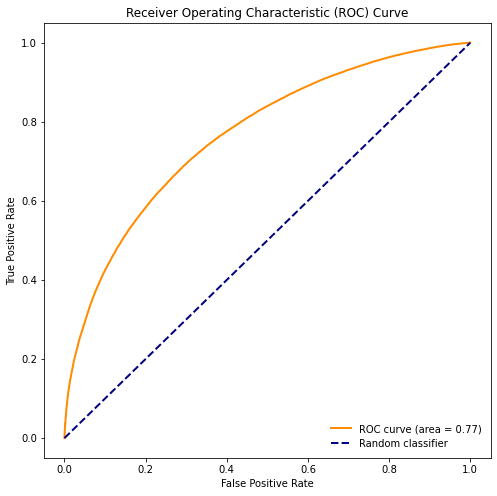

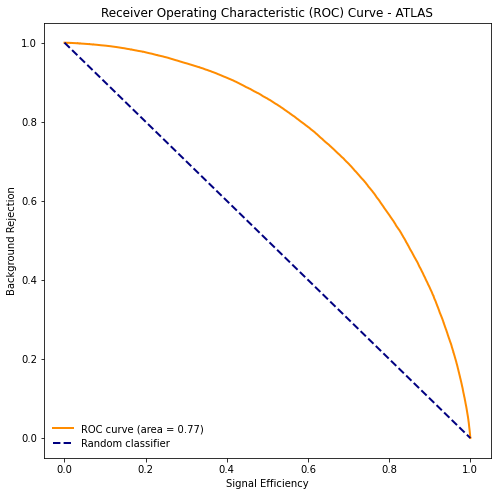

PR-AUC: 0.8692


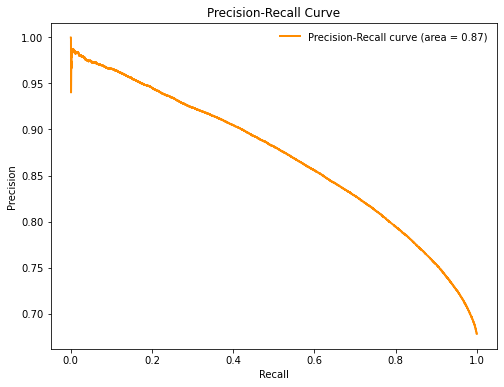

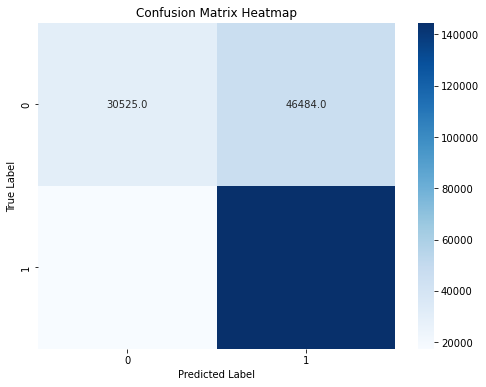

In [25]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(Y_test, Y_pred)
print(f'ROC-AUC Score: {roc_auc:.4f}')




plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random classifier")
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


plt.legend(loc='lower right',frameon=False)
plt.savefig(path_fig+"roc_curve.pdf")
plt.show()



plt.figure(figsize=(8, 8))
plt.plot(tpr, 1-fpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--', label="Random classifier")
    
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver Operating Characteristic (ROC) Curve - ATLAS')


plt.legend(loc='lower left',frameon=False)
plt.savefig(path_fig+"roc_curve_atlas.pdf")
plt.show()


precision, recall, _ = precision_recall_curve(Y_test, Y_pred)
auc_pr = auc(recall, precision)
print(f'PR-AUC: {auc_pr:.4f}')

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best',frameon=False)
plt.savefig(path_fig+"precision_recall_curve.pdf")
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.1f', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.savefig(path_fig+"confusion_matrix.pdf")
plt.show()

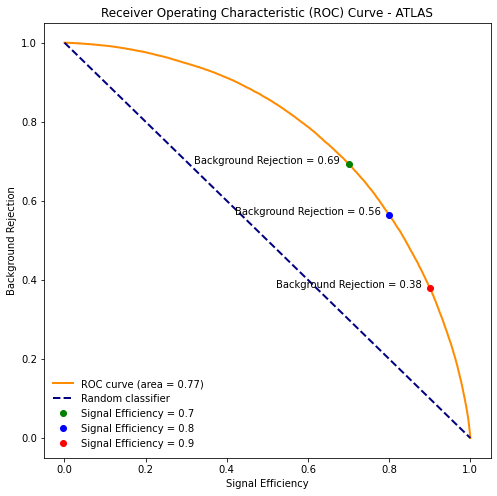

In [26]:
plt.figure(figsize=(8, 8))
plt.plot(tpr, 1 - fpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--', label="Random classifier")

color = ["g","b","r"]
for indx,i in enumerate([0.70,0.80,0.90]):
    signal_efficiency_interest = i
    index_interest = (np.abs(tpr - signal_efficiency_interest)).argmin()

    fpr_interest = fpr[index_interest]
    background_rejection_interest = 1 - fpr_interest
    

    plt.plot(signal_efficiency_interest, background_rejection_interest, 'o'+color[indx], label=f'Signal Efficiency = {i}')

    plt.annotate(f'Background Rejection = {background_rejection_interest:.2f}',
                 xy=(signal_efficiency_interest, background_rejection_interest),
                 xytext=(signal_efficiency_interest - 0.2, background_rejection_interest + 0.001),
                 ha='center')


plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver Operating Characteristic (ROC) Curve - ATLAS')


plt.legend(loc='lower left', frameon=False)
plt.savefig(path_fig+"roc_curve_atlas_cuts.pdf")
plt.show()
